In [6]:
from stateval.src.configs import MSAConfig
from stateval.src.msa import Msa 
from stateval.src.sh_entropies import ShannonEntropies 
from stat_eval_utils import fasta2dict


sequences = fasta2dict("./mdh_train_sample.fasta")
sequences = {id: seq for id, seq in zip(sequences["ID"], sequences["Seq"])}

msa = Msa(MSAConfig(max_gap_ratio=0.8))
aligned_seqs = msa.align(sequences)
se = ShannonEntropies()
entropies = se.calculate_entropies(aligned_seqs)


/opt/conda/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Using 3 threads
Read 500 sequences (type: Protein) from msa_input.fasta
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 15.14u 0.00s 00:00:15.14 Elapsed: 00:00:05
Guide-tree computation done.
Progressive alignment progress done. CPU time: 13.91u 0.10s 00:00:14.01 Elapsed: 00:00:08
Alignment written to _temp_msa_output.fasta


In [2]:
max([len(v) for v in sequences.values()])

430

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import yaml
from torch.nn import functional as F
import torch
with open('generation_config.yml', 'r') as file:
    config  = yaml.safe_load(file)

tokenizer = AutoTokenizer.from_pretrained(config["model_checkpoint_path"])
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a padding token
model = AutoModelForCausalLM.from_pretrained(config["model_checkpoint_path"], device_map="auto", load_in_8bit=True)
model.to_bettertransformer()
model.config.max_length = 512  #


loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Assigning [PAD] to the pad_token key of the tokenizer
loading configuration file ./output_mhd/checkpoint-4800/config.json
Model config GPT2Config {
  "_name_or_path": "./output_mhd/checkpoint-4800",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1280,
  "n_head": 20,
  "n_inner": null,
  "n_layer": 36,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",


In [6]:
next(model.parameters()).device

device(type='cuda', index=0)

In [12]:
from transformers.generation.logits_process import LogitsProcessor
from typing import List
class LogitEntropyProcessor(LogitsProcessor):
    
    def __init__(self, segments_indicies:List[int], temps:List[float], *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert len(temps) >= 1
        self.temps = temps
        self.segments_indicies = segments_indicies
        self.temp_index = 0
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
         
        scores = scores/ self.temps[self.temp_index]

        if input_ids.shape[1]+1 > self.segments_indicies[self.temp_index] and self.temp_index +1 < len(self.temps):
            self.temp_index += 1
        return scores


In [7]:
import numpy as np
n_segments = 7
indicies = np.linspace(0, len(entropies), n_segments+1).astype(int)
entropies_median = [np.median(entropies[indicies[i]: indicies[i+1]]) for i in range(n_segments)]
temps = [0.3+ v* 1.5 for v in entropies_median] # 0.3 as a base temp in case the entropy is too low 
temps


[0.9378,
 0.96915,
 0.9507000000000001,
 0.9848250000000001,
 1.0359,
 1.06935,
 1.1604]

In [25]:
from tqdm import tqdm
from transformers.generation import LogitsProcessorList
device = "cuda"
generated_sequences = []
batch_size = 8
seqs = fasta2dict("./mdh_train_sample.fasta")["Seq"]
for batch_idx in tqdm(range(0, len(sequences), batch_size)):
        inputs = tokenizer.batch_encode_plus(
            seqs[batch_idx:batch_idx+batch_size],
            padding="longest",
            truncation=True,
            max_length=512,  # Set the maximum length to 512
            return_tensors="pt"
        ).to(device)

        input_ids = inputs.input_ids
        attention_mask = inputs.attention_mask
        prompt = input_ids[:, :config["sequence_prompt_index"]]
        # Generate multiple prompt
        with torch.no_grad():

                outputs = model.generate(
                    prompt,
                    attention_mask=attention_mask[:, :config["sequence_prompt_index"]],
                    eos_token_id=0,
                    max_length=512,
                    logits_processor=LogitsProcessorList([LogitEntropyProcessor(segments_indicies=indicies[1:], temps=temps)]),
                    use_cache=True
                    
                    # num_return_sequences=5
                )
        for generated_output in outputs:
            generated_text = tokenizer.decode(generated_output, skip_special_tokens=True)
            generated_text = generated_text.replace("|endoftext|>", "")  # Remove the header
            generated_sequences.append(generated_text)


  0%|          | 0/63 [00:00<?, ?it/s]Generate config GenerationConfig {
  "bos_token_id": 0,
  "eos_token_id": 0,
  "max_length": 512
}

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  2%|▏         | 1/63 [00:09<09:46,  9.45s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "eos_token_id": 0,
  "max_length": 512
}

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  3%|▎         | 2/63 [00:19<10:00,  9.85s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "eos_token_id": 0,
  "max_length": 512
}

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  5%|▍         | 3/63 [00:29<09:51,  9.86s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "eos_token_id": 0,
  "max_length": 512
}

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  6%|▋         | 4/63 [00:39<09:34,  9.75s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "eos_token_id": 0,
  "max_length": 512
}

Settin

KeyboardInterrupt: 

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
         30., 282., 173.,   5.,   3.,   2.,   0.,   2.,   1.]),
 array([126. , 141.2, 156.4, 171.6, 186.8, 202. , 217.2, 232.4, 247.6,
        262.8, 278. , 293.2, 308.4, 323.6, 338.8, 354. , 369.2, 384.4,
        399.6, 414.8, 430. ]),
 <BarContainer object of 20 artists>)

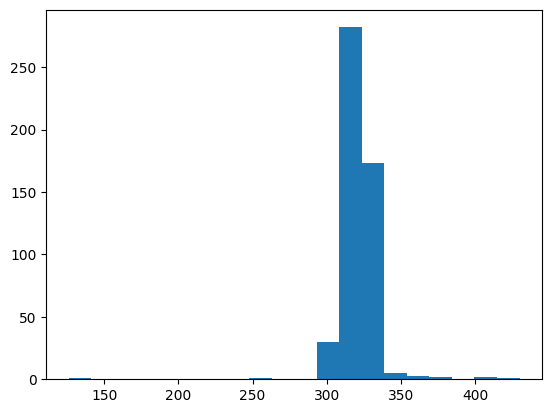

In [23]:
plt.hist([len(s) for s in seqs], bins=20)


(array([  7.,   2.,   0.,   1.,   4.,   4.,   2.,   0.,   1.,   0.,  78.,
        400.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  14.  ,   41.08,   68.16,   95.24,  122.32,  149.4 ,  176.48,
         203.56,  230.64,  257.72,  284.8 ,  311.88,  338.96,  366.04,
         393.12,  420.2 ,  447.28,  474.36,  501.44,  528.52,  555.6 ,
         582.68,  609.76,  636.84,  663.92,  691.  ,  718.08,  745.16,
         772.24,  799.32,  826.4 ,  853.48,  880.56,  907.64,  934.72,
         961.8 ,  988.88, 1015.96, 1043.04, 1070.12, 1097.2 , 1124.28,
        1151.36, 1178.44, 1205.52, 1232.6 , 1259.68, 1286.76, 1313.84,
        1340.92, 1368.  ]),
 <BarContainer object of 50 artists>)

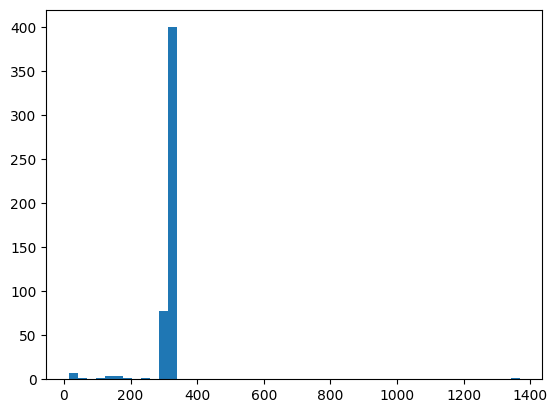

In [24]:
import matplotlib.pylab as plt

plt.hist([len(s) for s in generated_sequences], bins=50)